In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import time

start_time = time.time()

In [86]:
# load the datasets
train_input = pd.read_csv('/Users/aran/Desktop/Semester 1/Introduction to machine learning/assignments/SVD assignment/Data/trainInput.csv', header = None).values
train_output = pd.read_csv('/Users/aran/Desktop/Semester 1/Introduction to machine learning/assignments/SVD assignment/Data/trainOutput.csv', header = None).values.flatten()

test_input = pd.read_csv('/Users/aran/Desktop/Semester 1/Introduction to machine learning/assignments/SVD assignment/Data/testInput.csv', header = None).values
test_output = pd.read_csv('/Users/aran/Desktop/Semester 1/Introduction to machine learning/assignments/SVD assignment/Data/testOutput.csv', header = None).values.flatten()

print(train_input.shape)
print(train_output.shape)
print(test_input.shape)
print(test_output.shape)

#when we load the csv file the train_output and test_output are in 2D array with a shape (1707, 1) (for train_output) or (2007, 1) (for test_output), Flattening these arrays converts them to 1D array making the simpler to work


(256, 1707)
(1707,)
(256, 2007)
(2007,)


In [87]:
# Transpose train_input and test_input so each row represents an image (16x16 flattened to 256 pixels)
train_input = train_input.T
test_input = test_input.T

print(train_input.shape)
print(test_input.shape) 


(1707, 256)
(2007, 256)


The reason we transpose train_input and test_input is to ensure that each row represents an individual image and each column represents a pixel

One of the ERROR faced in the assignment is Dimension Mismatch Without Transposing 
If we don’t transpose train_input, it initially has a shape of (256, 1707), where
256 represents pixels.
1707 represents images (one image per column).

When we try to use boolean indexing with train_output (which has 1707 elements), it leads to an indexing error because train_input and train_output don’t align along the same dimension.

In [89]:
#Group training images by digit to create a matrix for each digit
# Each digit matrix will contain all images of that digit with each image as a row
A = {}

for digit in range(10):
    A[digit] = train_input[train_output==digit,:]

for i in range(10):
    print(f"Digit {i} : {A[i].shape}")

Digit 0 : (319, 256)
Digit 1 : (252, 256)
Digit 2 : (202, 256)
Digit 3 : (131, 256)
Digit 4 : (122, 256)
Digit 5 : (88, 256)
Digit 6 : (151, 256)
Digit 7 : (166, 256)
Digit 8 : (144, 256)
Digit 9 : (132, 256)


By transposing, train_input becomes (1707, 256), making the boolean indexing train_input[train_output == digit, :] valid, as both now share the same number of rows (1707).

#### Right Singular Vectors
(But when we even try with left singular vectors we get the same 93 percent  accuracy)

In [92]:
k = 20 # Number of top singular vectors to retain for each digit
singular_vectors = {} # dictionary to store singular vectors 

# Loop through each digit and calculate its singular vectors
for digit, matrix in A.items():

    
    # Performing Singular Value Decomposition (SVD) on the matrix of each digit
    # U, S, and Vt are the left singular vectors, singular values, and right singular vectors, respectively
    U, S, Vt = np.linalg.svd(matrix, full_matrices=False)
    

    # Select the first k right singular vectors (Vt[:k, :]) to form the basis for the digit
    # These right singular vectors capture the most important patterns for that digit's image space
    singular_vectors[digit] = Vt[:k,:]


# Verify the shapes of the basis vectors for each digit to ensure correct dimensions
for i in range(10):
    print(f"basis shape {i} : {singular_vectors[i].shape}")


basis shape 0 : (20, 256)
basis shape 1 : (20, 256)
basis shape 2 : (20, 256)
basis shape 3 : (20, 256)
basis shape 4 : (20, 256)
basis shape 5 : (20, 256)
basis shape 6 : (20, 256)
basis shape 7 : (20, 256)
basis shape 8 : (20, 256)
basis shape 9 : (20, 256)


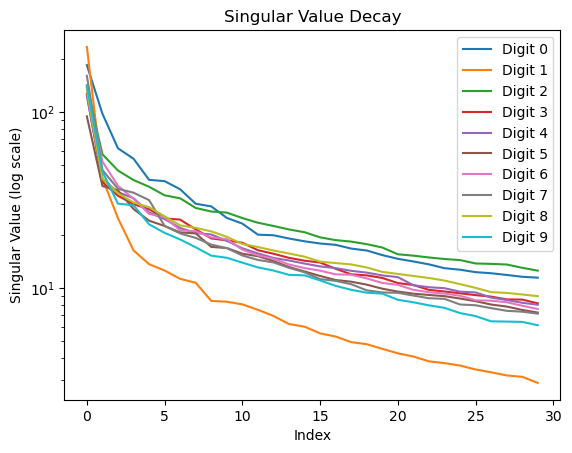

In [93]:
fig, ax = plt.subplots()
for digit in range(10):
    _, singular_values, _ = np.linalg.svd(A[digit], full_matrices=False)
    ax.plot(singular_values[:30], label=f"Digit {digit}")  # Plot first 30 singular values
ax.set_yscale('log')
ax.set_title("Singular Value Decay")
ax.set_xlabel("Index")
ax.set_ylabel("Singular Value (log scale)")
ax.legend()
plt.show()

Rapid decay indicates that only a few components capture most of the information, validating why using only the top k=20 singular vectors can still produce an effective model without retaining unnecessary complexity.

In [95]:
predictions = []

for test_image in test_input:
    residuals = []
    for digit in range(10):
        basis = singular_vectors[digit] # Get the basis (top 20 singular vectors) for the current digit
        
        # We Solve the least squares problem to find coefficients that approximate the test image using the digit's basis
        # We use basis.T to match the (256, 20) shape with the test image shape (256,)
        coefficients = np.linalg.lstsq(basis.T,test_image,rcond=None)[0]

        # By reconstructing the test image approximation from the basis and coefficients
        # This gives an approximation in the digit's "space"
        approximation = basis.T @ coefficients
        
        # Calculate the residual (Euclidean distance) between the test image and its approximation
        # The smaller the residual, the better this digit's basis represents the test image
        residual = np.linalg.norm(test_image.flatten() - approximation)
        
        residuals.append(residual)

    # Find the digit with the smallest residual and add it to predictions
    predicted_digit = np.argmin(residuals)
    predictions.append(predicted_digit)
print(coefficients.shape)
print(basis.T.shape)

(20,)
(256, 20)


The residual represents the difference between the test image and its reconstruction using each digit's basis (set of singular vectors). A smaller residual indicates a better match.
This process is based on the assumption that the correct digit will yield the smallest approximation error since it shares more features with the test image.
The predicted digit (with the smallest residual) is appended to predictions, allowing us to collect the predicted labels for all test images.

In [97]:
#This function compares test_output (the true labels of the test images) with predictions (the predicted labels).
accuracy = accuracy_score(test_output, predictions)
print(f"Overall Classification Accuracy: {accuracy * 100:.2f}%")


Overall Classification Accuracy: 93.97%


In [98]:
conf_matrix = confusion_matrix(test_output, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[355   0   2   0   1   0   0   0   0   1]
 [  0 259   0   0   3   0   2   0   0   0]
 [  8   1 179   2   3   0   0   1   4   0]
 [  1   0   4 148   1   8   0   1   2   1]
 [  1   1   0   0 187   1   1   3   0   6]
 [  8   1   2   4   0 140   0   0   2   3]
 [  2   0   0   0   2   2 164   0   0   0]
 [  0   1   1   0   3   0   0 139   0   3]
 [  4   0   2   6   0   1   0   0 149   4]
 [  0   1   0   1   4   0   0   4   1 166]]


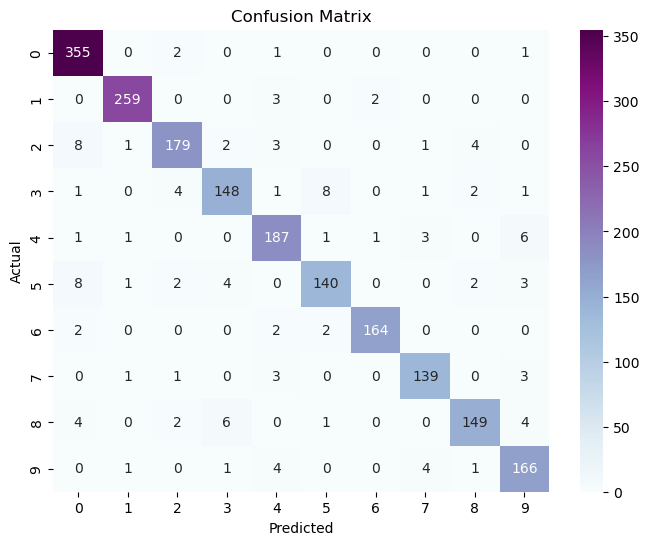

In [99]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="BuPu", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

This function compares test_output (Actual labels) with predictions (predicted labels).
The result is a matrix where each row represents the actual digit, and each column represents the predicted digit.
The diagonal entries show the number of correctly classified images for each digit, while off-diagonal entries indicate misclassifications.


In [101]:
# Calculate per-digit accuracy
digit_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for digit, acc in enumerate(digit_accuracies):
    print(f"Accuracy for digit {digit}: {acc * 100:.2f}%")

# Identify the digits with the highest and lowest classification rates
highest_accuracy_digit = np.argmax(digit_accuracies)
lowest_accuracy_digit = np.argmin(digit_accuracies)
print(f"Highest classification accuracy: Digit {highest_accuracy_digit} with {digit_accuracies[highest_accuracy_digit] * 100:.2f}%")
print(f"Lowest classification accuracy: Digit {lowest_accuracy_digit} with {digit_accuracies[lowest_accuracy_digit] * 100:.2f}%")

Accuracy for digit 0: 98.89%
Accuracy for digit 1: 98.11%
Accuracy for digit 2: 90.40%
Accuracy for digit 3: 89.16%
Accuracy for digit 4: 93.50%
Accuracy for digit 5: 87.50%
Accuracy for digit 6: 96.47%
Accuracy for digit 7: 94.56%
Accuracy for digit 8: 89.76%
Accuracy for digit 9: 93.79%
Highest classification accuracy: Digit 0 with 98.89%
Lowest classification accuracy: Digit 5 with 87.50%


Additional information

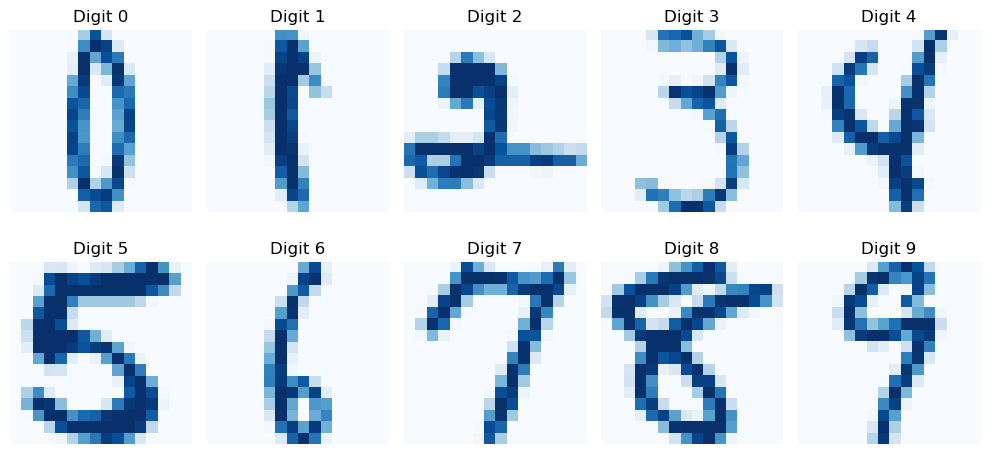

In [103]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    sample_images = train_input[train_output == i][:5]  # Select 5 images for each digit
    for j, img in enumerate(sample_images):
        ax = axes[i // 5, i % 5]
        ax.imshow(img.reshape(16, 16),cmap='Blues')
        ax.axis('off')
        ax.set_title(f"Digit {i}")
plt.tight_layout()
plt.show()


This visualization allows us to understand how similar or distinct digits are within their own class, which may affect the model’s performance.
Observing multiple samples of each digit helps in understanding the range of handwriting styles, stroke variations, and possible distortions for each number. This insight is important because it highlights the complexity of the classification task and shows the model's challenge in accurately learning distinct features for each digit despite intra-class variations.

In [105]:
end_time = time.time()  # End time
print(f"Runtime: {end_time - start_time:.2f} seconds")

Runtime: 2.12 seconds


Bibliography:
Kaggle
Gemini
Github